In [11]:
from collections import defaultdict, Counter 
import colorsys
import itertools
import pickle 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy.spatial import distance, ConvexHull
from scipy.stats import spearmanr
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import fcsparser 
from ete3 import Tree, TreeNode, TreeStyle, TextFace

data_dir = '.'

In [12]:
supplementary_data = pd.read_csv('../Suppl.Table2.CODEX_paper_MRLdatasetexpression.csv')
supplementary_data = supplementary_data[['X.X', 'Y.Y', 'Z.Z', 'sample_Xtile_Ytile', 
                                         'CD45', 'Imaging phenotype cluster ID']]
supplementary_data.rename(columns={'X.X': 'X', 'Y.Y': 'Y', 'Z.Z': 'Z'}, inplace=True)
supplementary_data['CD45_int'] = supplementary_data['CD45'].astype(int)
supplementary_annotations = pd.read_excel('../Suppl.Table2.cluster annotations and cell counts.xlsx')
dirt = supplementary_annotations.loc[supplementary_annotations['Imaging phenotype (cell type)'] == 'dirt', 'X-shift cluster ID']
# remove dirt from supplementary data 
supplementary_data = supplementary_data[~supplementary_data['Imaging phenotype cluster ID'].isin(dirt)]

def convert_coordinates(df, tile_length=1342, tile_width=1006):
    df['tile_x'] = df['sample_Xtile_Ytile'].apply(lambda x: int(x.split('_')[1][2])) - 1
    df['tile_y'] = df['sample_Xtile_Ytile'].apply(lambda x: int(x.split('_')[2][2])) - 1
    df['X'] = tile_length * df['tile_x'] + df['X']
    df['Y'] = tile_width * df['tile_y'] + df['Y']
    
    return df

def process_fcs(df):
    df.rename(columns={'F4': 'F480', 'CD16': 'CD1632', 'CD21': 'CD2135', 
                       'X.X': 'X', 'Y.Y': 'Y', 'Z.Z': 'Z'}, inplace=True)
    df['CD45_int'] = df['CD45'].astype(int)
    df = pd.merge(df, supplementary_data, on=['X', 'Y', 'Z', 'CD45_int'])
    df = convert_coordinates(df)
    df.drop(['CD45_int'], axis=1, inplace=True)
    
    return df

def get_clusters(sample_name):
    #all_neighbors = list(reversed(range(5, 100+1)))
    all_neighbors = list(reversed(range(5, 500+1, 5)))
    nn_nums = []
    num_clusters = []
    for nn in all_neighbors:
        try:
            _, data = fcsparser.parse(data_dir + '/' + sample_name + '/' + str(nn) + '/out/' + sample_name + '.fcs') 
            clusters = len(np.unique(data['cluster_id']))
            if clusters < 300: # hacky method right now to reduce size of tree 
                num_clusters.append(clusters)
                nn_nums.append(nn)
        except:
            continue
    
    return num_clusters, nn_nums

def get_unique_clusters(sample_name):
    num_clusters, nn_nums = get_clusters(sample_name)
    dist_neighbors, dist_clusters = [], []
    for i in range(len(num_clusters)):
        if i > 0 and num_clusters[i] != num_clusters[i-1]:
            dist_neighbors.append(nn_nums[i])
            dist_clusters.append(num_clusters[i])
    
    return dist_clusters, dist_neighbors

In [39]:
def add_tree_layer(tree, leaves, clusters, proportions, child_coords, prop_filter):
    '''
    tree: tree that we want to add an additional layer to
    leaves: leaves of tree 
    clusters: number of clusters in the child layer
    proportions: nested dictionary containing id of parent and id of child and the proportion of cells 
                 contained in the parent that are also contained in the child 
    prop_filter: proportion of cells for edge between clusters to be created 
    '''
    child_nodes = {}
    for ind in range(len(clusters)):
        child_node_id = clusters[ind]
        child_nodes[child_node_id] = TreeNode(name=child_node_id)
        # add coordinate data to node 
        child_nodes[child_node_id].add_features(coords=child_coords[child_node_id]) 
        child_nodes[child_node_id].add_features(cluster_id=child_node_id)
    for child_node_id in proportions:
        # ensure that each child node is not added to more than one parent node 
        proportions_child = proportions[child_node_id]
        max_node_id = max(proportions_child, key=proportions_child.get)
        if proportions_child[max_node_id] > prop_filter:
            parent_node = leaves[max_node_id]
            parent_node.add_child(child_nodes[child_node_id])
                
    return tree, child_nodes
    
def build_tree(fcs_paths, num_neighbors, prop_filter=0.1):
    '''
    fcs_paths: dictionary of (cluster numbers, path)
    num_neighbors: number of neighbors used in X-shift 
    prop_filter: proportion of cells for edge between clusters to be created 
    '''
    # first initialize tree with 1 node at top and its children 
    tree = TreeNode(name=0)
    leaves = {0: tree}
    _, cluster_data_child = fcsparser.parse(fcs_paths[0])
    cluster_data_child = process_fcs(cluster_data_child)
    tree.add_features(coords=cluster_data_child[['X', 'Y', 'Z']])
    tree.add_features(cluster_id=0)
    child_cluster_counts = cluster_data_child['cluster_id'].value_counts()
    child_coords = cluster_data_child[['cluster_id', 'X', 'Y', 'Z']]
    child_coords_groupby = child_coords.groupby('cluster_id')
    child_coords = {group: child_coords.loc[inds, ['X', 'Y', 'Z']]
                    for group, inds in child_coords_groupby.groups.items()}
    clusters = list(child_cluster_counts.keys())
    child_cluster_counts /= child_cluster_counts.sum()
    proportions = {}
    for child_node_id, val in child_cluster_counts.iteritems():
        proportions[child_node_id] = {0: val}
    # set proportion filter to 0 for first layer, as everything is a child of the vertex
    tree, leaves = add_tree_layer(tree, leaves, clusters, proportions, child_coords, prop_filter=0)
    
    # build the rest of the tree 
    for ind, nn in enumerate(num_neighbors[:-1]):
        _, cluster_data_parent = fcsparser.parse(fcs_paths[ind])
        _, cluster_data_child = fcsparser.parse(fcs_paths[ind+1])
        cluster_data_parent = process_fcs(cluster_data_parent)
        cluster_data_child = process_fcs(cluster_data_child)
        
        child_cluster_counts = cluster_data_child['cluster_id'].value_counts()
        clusters = list(child_cluster_counts.keys())
        match_data_parent = cluster_data_parent[['X', 'Y', 'Z', 'cluster_id']].astype(int)
        match_data_child = cluster_data_child[['X', 'Y', 'Z', 'cluster_id']].astype(int)
        merged = pd.merge(match_data_parent, match_data_child, on=['X', 'Y', 'Z'])
        parent_clusters = merged['cluster_id_x'].tolist()
        child_clusters = merged['cluster_id_y'].tolist()
        child_coords = cluster_data_child[['cluster_id', 'X', 'Y', 'Z']]
        child_coords_groupby = child_coords.groupby('cluster_id')
        child_coords = {group: child_coords.loc[inds, ['X', 'Y', 'Z']]
                        for group, inds in child_coords_groupby.groups.items()}
        proportions = defaultdict(Counter)
        for parent_cluster, child_cluster in zip(parent_clusters, child_clusters):
            proportions[child_cluster][parent_cluster] += 1/child_cluster_counts[child_cluster]
        tree, leaves = add_tree_layer(tree, leaves, clusters, proportions, child_coords, prop_filter)
        
    return tree 

def get_grid_counts(node, grid_size=25):
    '''
    Divide points into a grid, and get the count of the number of points
    in each grid cell in the child and parent. 
    '''
    root = node.get_tree_root()
    x_max, y_max = root.coords['X'].max(), root.coords['Y'].max()
    x_length, y_length = x_max / grid_size, y_max / grid_size
    grid_coords = itertools.product(range(grid_size), range(grid_size))
    grid_x_child, grid_y_child = node.coords['X'] // x_length, node.coords['Y'] // y_length
    grid_child = Counter(zip(grid_x_child, grid_y_child))
    grid_x_parent, grid_y_parent = node.up.coords['X'] // x_length, node.up.coords['Y'] // y_length
    grid_parent = Counter(zip(grid_x_parent, grid_y_parent))
    grid_child_counts, grid_parent_counts = [], []
    for grid_coord_tuple in grid_coords:
        grid_child_counts.append(grid_child[grid_coord_tuple])
        grid_parent_counts.append(grid_parent[grid_coord_tuple])
        
    return grid_child_counts, grid_parent_counts

def spearman_corr_change(node, grid_size=25):
    '''
    Partition the image into a grid, and compute the fraction of cells in each cell of the grid. 
    We then compute the spearman correlation between the parent and child cluster using these values. 
    ''' 
    grid_child_counts, grid_parent_counts = get_grid_counts(node, grid_size)
    spearman_corr, _ = spearmanr(grid_child_counts, grid_parent_counts)
    
    return spearman_corr

In [40]:
def build_sample_tree(sample_name, prop_filter=0.1):
    num_clusters, num_neighbors = get_unique_clusters(sample_name)
    fcs_paths = [data_dir + '/' + sample_name + '/' + str(nn) + '/out/' + sample_name + '.fcs' for nn in num_neighbors]
    tree = build_tree(fcs_paths, num_neighbors, prop_filter)
    return tree

def hls2hex(h, l, s):
    return '#%02x%02x%02x' % tuple(map(lambda x: int(x*255),
                                      colorsys.hls_to_rgb(h, l, s)))    

def recreate_tree(tree, num_layers=None):
    # build tree with same topology but without the coordinate and metadata labels 
    # use color_dict to color nodes the appropriate colors 
    new_tree = TreeNode(name = tree.name)
    #new_tree = TreeNodeHashable(name = tree.name)
    new_tree.img_style['size'] = 10
    new_tree.img_style['fgcolor'] = tree.color
    new_tree.img_style['shape'] = 'sphere'
    old_layer = [tree]
    new_layer = [new_tree]
    layer_num = 0
    while old_layer:
        next_old_layer, next_new_layer = [], []
        for ind, node in enumerate(old_layer):
            for child in node.children:
                next_old_layer.append(child)
                new_child = TreeNode(name = child.name)
                #new_child = TreeNodeHashable(name = child.name)
                new_child.img_style['size'] = 10
                new_child.img_style['fgcolor'] = child.color
                new_child.img_style['shape'] = 'sphere'
                new_layer[ind].add_child(new_child)
                next_new_layer.append(new_child)
        old_layer = next_old_layer
        new_layer = next_new_layer
        layer_num += 1
        if num_layers is not None and layer_num == num_layers:
            break
        
    return new_tree

In [41]:
def visualize_spearman_metric(num_layers=None, save=True):
    # visualize tree where we color each node based on the value of the spearman metric 
    tree.add_features(color=hls2hex(0.95, 0.95, 0.95))
    for node in tree.iter_descendants():
        node.add_features(color=hls2hex((1+node.metric)*0.475, (1+node.metric)*0.475, (1+node.metric)*0.475))

    new_tree = recreate_tree(tree, num_layers)
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.rotation = 90
    if save:
        new_tree.render('metric_tree.png', tree_style=ts)
    else:
        return new_tree.render('%%inline', tree_style=ts)
    
def calculate_spearman_metric(tree):
    for node in tree.iter_descendants():
        node.add_features(metric=spearman_corr_change(node))
    return tree
    
def parse_metric_tree(tree, num_layers=None, cutoff=0.5, return_tree=False, save=True, prevent_nondicotomic=True):
    # remove cluster nodes with spearman correlation less than cutoff
    parsed_tree = tree.copy()
    deleted = set()
    for node in parsed_tree.iter_descendants():
        if node.metric > cutoff:
            node.delete(prevent_nondicotomic=prevent_nondicotomic)
            
    if return_tree:
        return parsed_tree
    
    parsed_tree.add_features(color=hls2hex(0.95, 0.95, 0.95))
    for node in parsed_tree.iter_descendants():
        node.add_features(color=hls2hex((1+node.metric)*0.475, (1+node.metric)*0.475, (1+node.metric)*0.475))
    new_tree = recreate_tree(parsed_tree, num_layers)
    ts = TreeStyle()
    ts.show_leaf_name = False
    ts.rotation = 90
    if save:
        new_tree.render('metric_tree_parsed.png', tree_style=ts)
    else:
        return new_tree.render('%%inline', tree_style=ts)
    
def visualize_metric_tree_clusters(parsed_metric_tree):
    total_nodes = len(list(parsed_metric_tree.iter_descendants()))
    for ind, node in enumerate(parsed_metric_tree.iter_descendants()):
        if ind % 5 == 0:
            fig, ax = plt.subplots(1, 5, figsize=(20, 4))
        ax[ind%5].scatter(node.coords['X'], node.coords['Y'], s=0.1)
        if ind % 5 == 4:
            plt.show()
    if ind % 5 != 4:
        for i in range(1, 5 - ind%5):
            ax[ind%5 + i].axis('off')
        plt.show()
        
def find_corresponding_cluster(clusters1, clusters2):
    # for each cluster in clusters1, find the most similar cluster in clusters2, and plot them side by side 
    for cluster1 in clusters1:
        cluster2_ind, cluster2_frac = 0, 0
        for ind, cluster2 in enumerate(clusters2):
            intersection_ratio = pd.merge(cluster1, cluster2, how='inner').shape[0]/cluster1.shape[0]
            if intersection_ratio > cluster2_frac:
                cluster2_ind = ind
                cluster2_frac = intersection_ratio
        cluster2 = clusters2[cluster2_ind]
        fig, ax = plt.subplots(1, 2)
        ax[0].scatter(cluster1['X'], cluster1['Y'], s=0.1)
        ax[1].scatter(cluster2['X'], cluster2['Y'], s=0.1)
        plt.show()
        
def plot_cluster_overlap_heatmap(clusters1, clusters2):
    # plot a heatmap of the overlap between each cluster in clusters1 and each cluster in clusters2
    overlap = np.zeros((len(clusters1), len(clusters2)))
    for ind1, cluster1 in enumerate(clusters1):
        for ind2, cluster2 in enumerate(clusters2):
            intersection = pd.merge(cluster1, cluster2, on=['X', 'Y'], how='inner').shape[0]
            union = pd.merge(cluster1, cluster2, on=['X', 'Y'], how='outer').shape[0]
            overlap[ind1, ind2] = intersection / union
            
    plt.imshow(overlap)
    plt.colorbar()
    plt.show()
        
def plot_layer_overlap_heatmap(tree, suppl_coords, num_layers=None):
    # plot heatmap of overlap between layers of tree and supplementary clusters 
    layer = [tree]
    layer_num = 0
    while layer:
        new_layer = []
        for node in layer:
            new_layer += node.children
        layer = new_layer
        node_coords = [node.coords[['X', 'Y']] for node in layer]
        print('Layer with {} nodes'.format(len(node_coords)))
        plot_cluster_overlap_heatmap(node_coords, suppl_coords)
        layer_num += 1
        if num_layers is not None and layer_num == num_layers:
            break

In [6]:
sample_name = 'BALBc-1'
num_clusters, num_neighbors = get_unique_clusters(sample_name)
fcs_paths = [data_dir + '/' + sample_name + '/' + str(nn) + '/out/' + sample_name + '.fcs' for nn in num_neighbors]
tree = build_sample_tree(sample_name, prop_filter=0.15)
tree = calculate_spearman_metric(tree)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)
/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


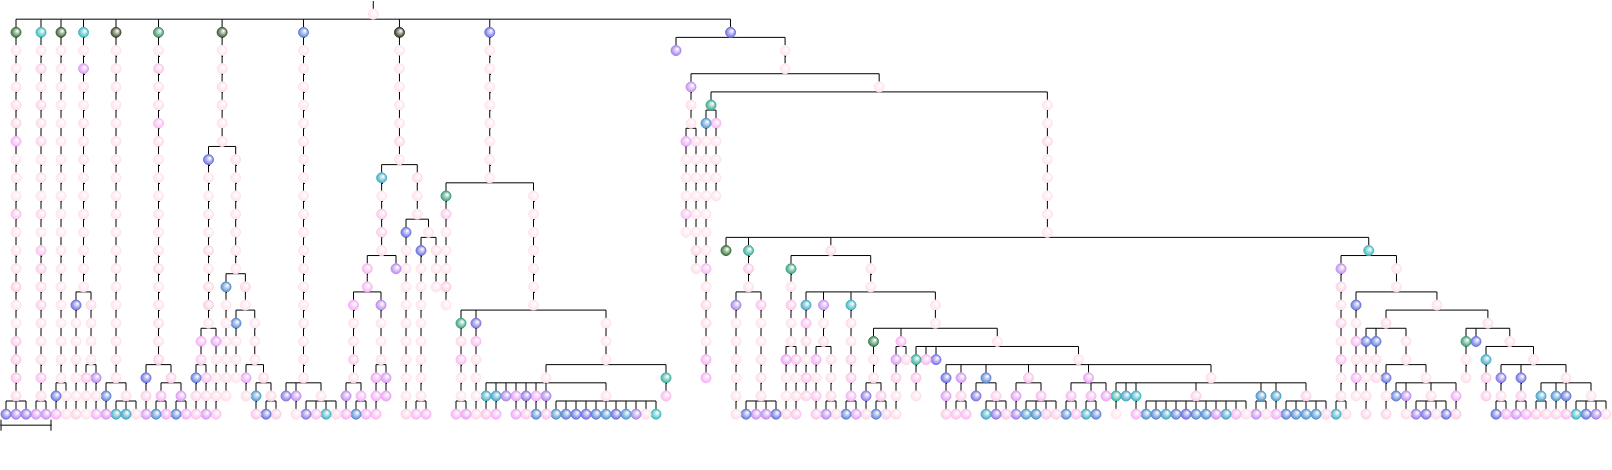

In [18]:
visualize_spearman_metric(num_layers=25, save=False)

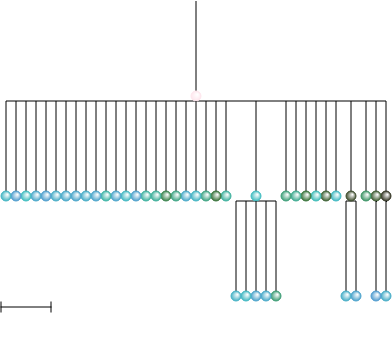

In [20]:
parse_metric_tree(tree, num_layers=None, cutoff=0.2, prevent_nondicotomic=False, save=False)

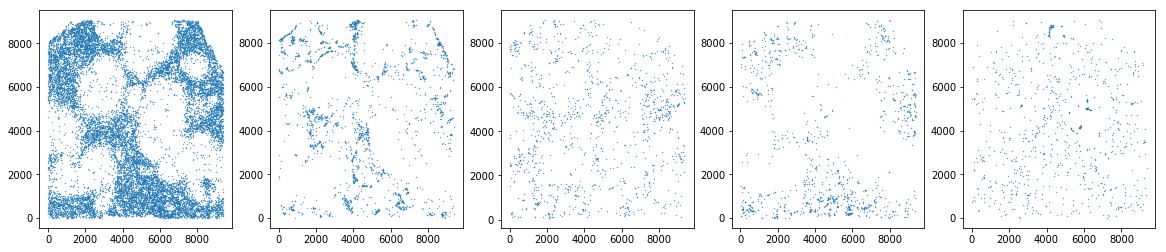

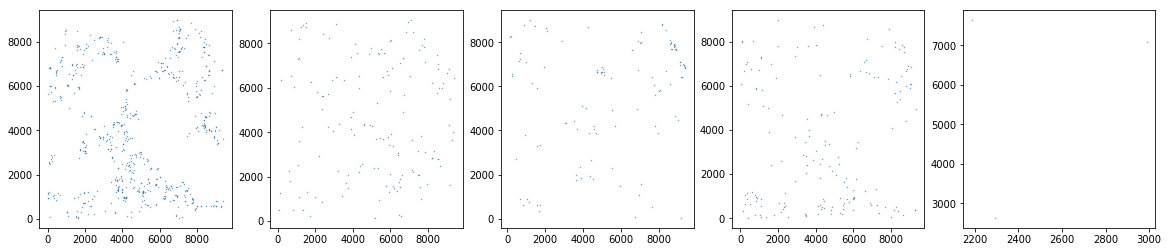

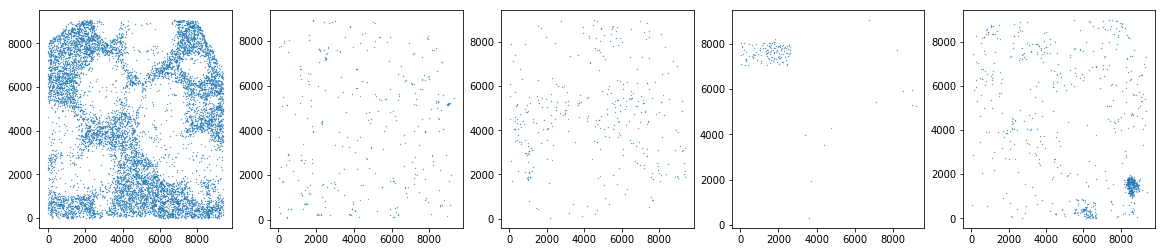

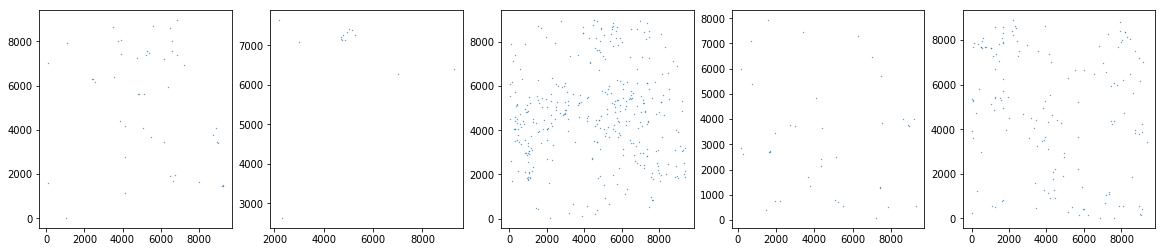

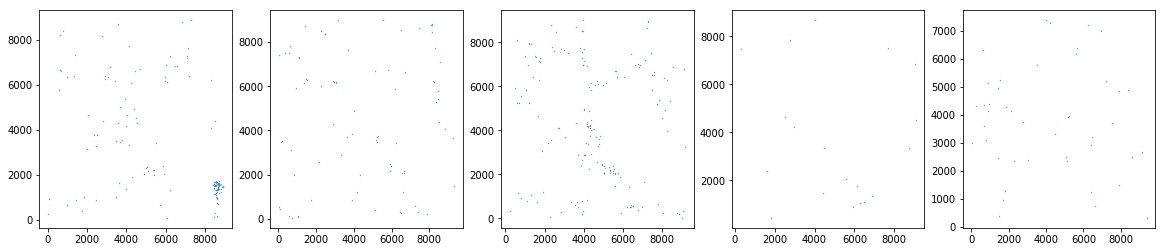

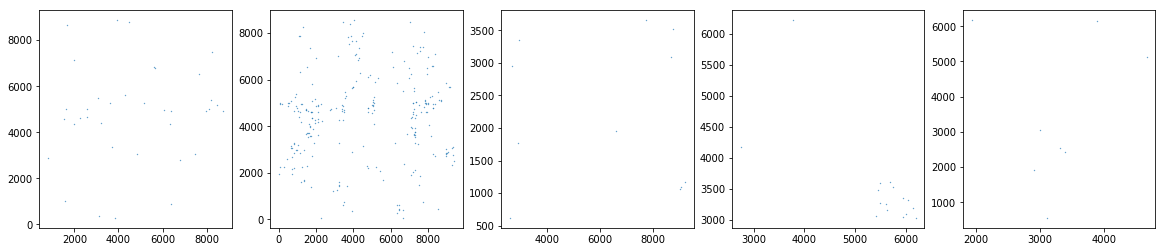

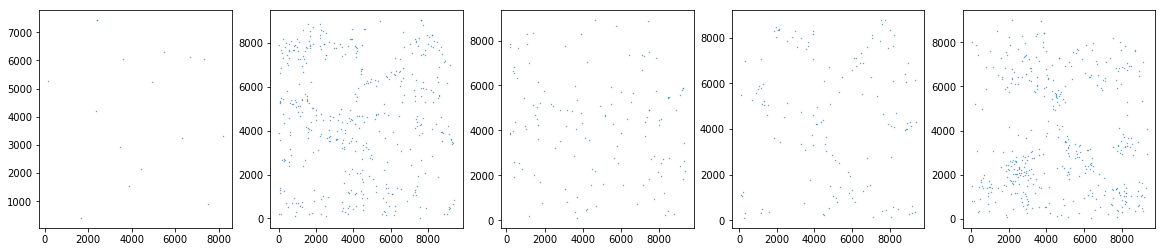

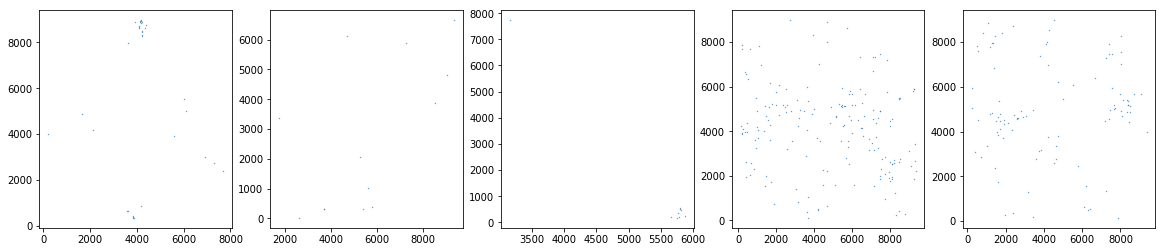

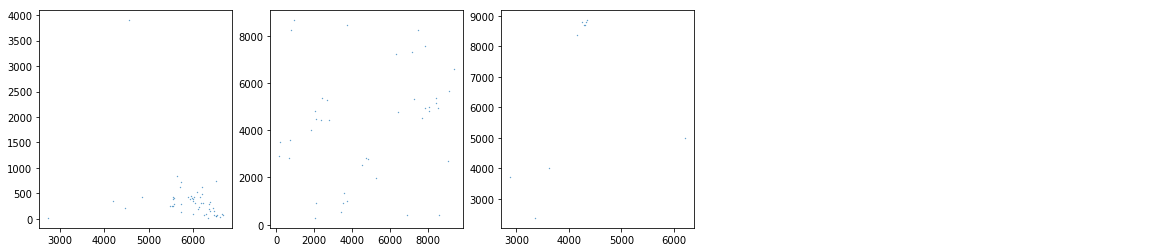

In [21]:
parsed_metric_tree = parse_metric_tree(tree, num_layers=5, cutoff=0.2, return_tree=True, prevent_nondicotomic=False)
visualize_metric_tree_clusters(parsed_metric_tree)

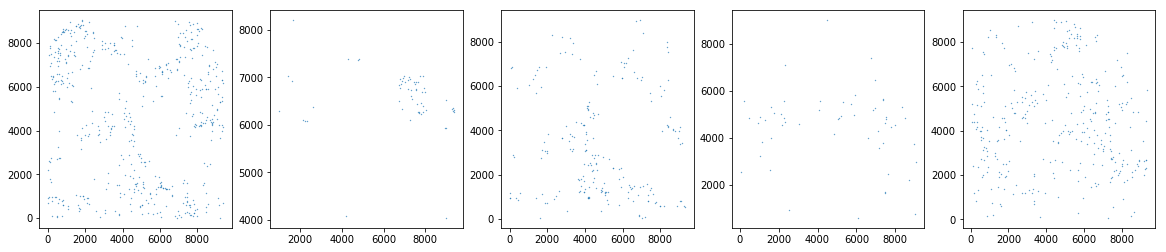

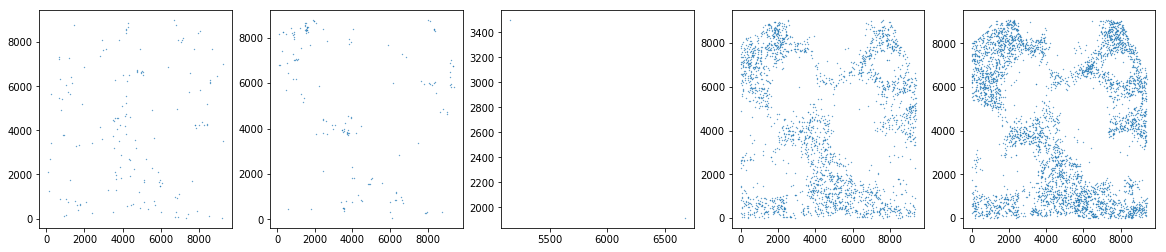

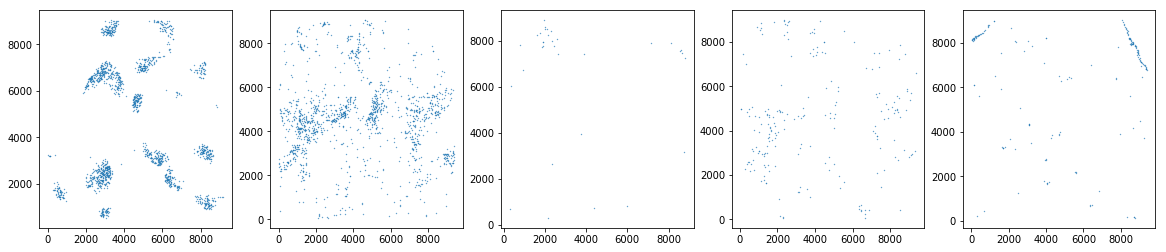

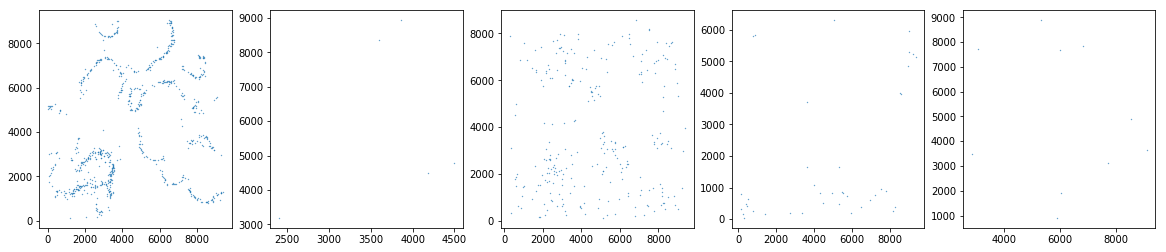

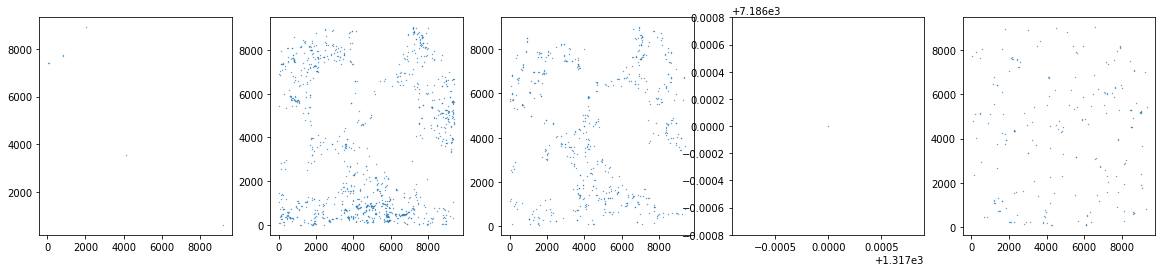

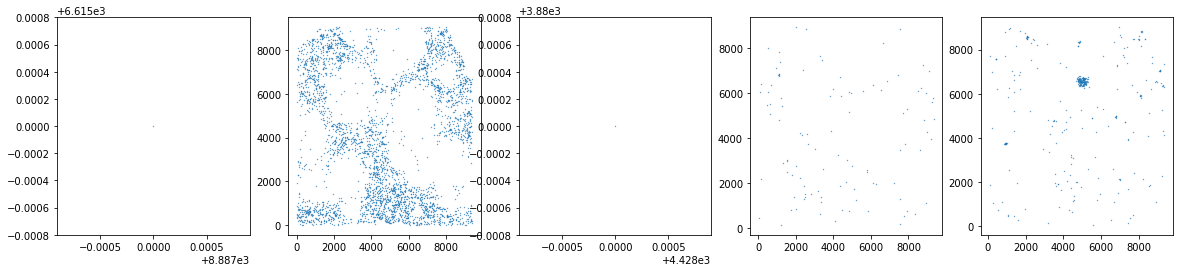

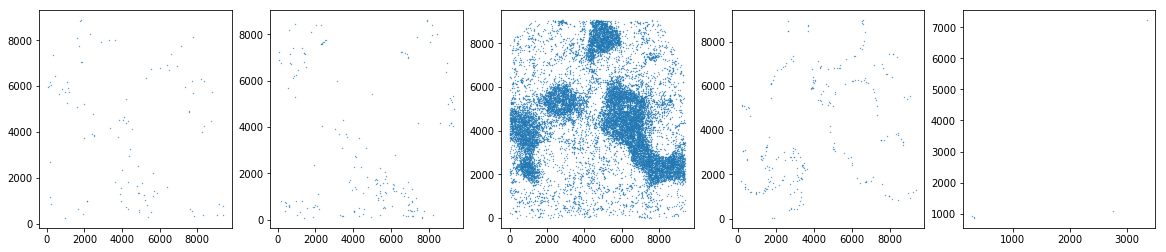

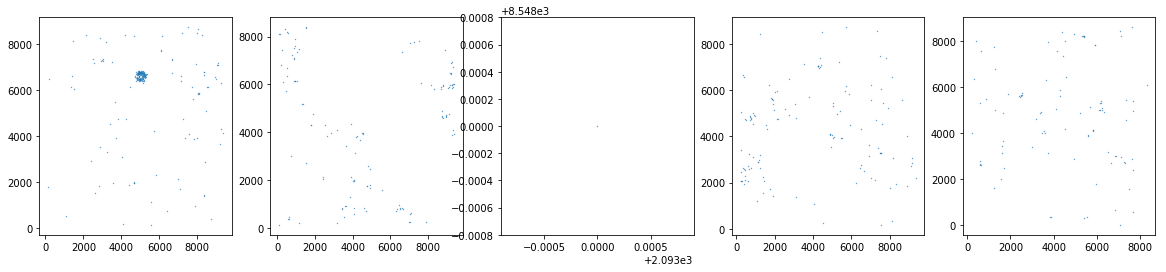

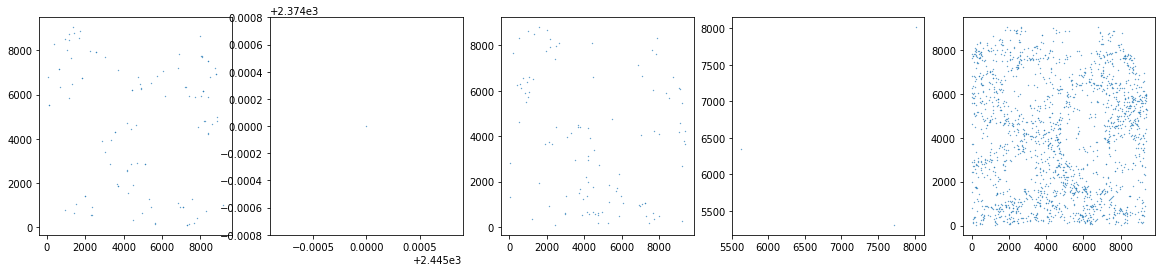

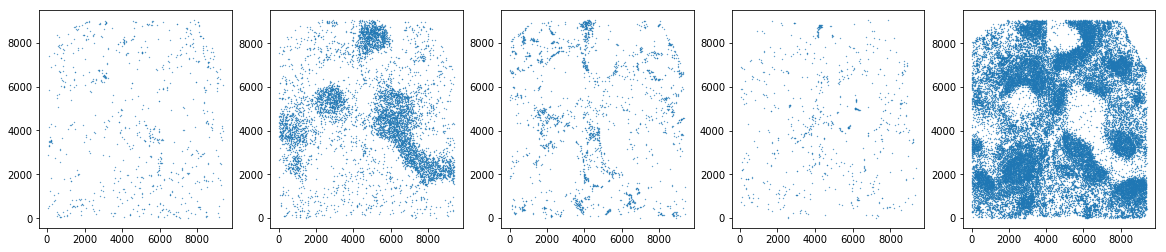

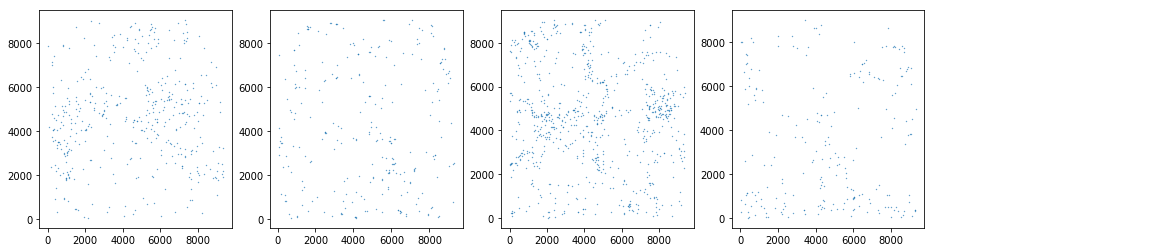

In [22]:
supplementary_data = pd.read_csv('../Suppl.Table2.CODEX_paper_MRLdatasetexpression.csv')
supplementary_data = supplementary_data[['X.X', 'Y.Y', 'Z.Z', 'sample_Xtile_Ytile', 
                                         'CD45', 'Imaging phenotype cluster ID']]
supplementary_data = supplementary_data[supplementary_data['sample_Xtile_Ytile'].str.contains('BALBc-1')]
supplementary_data.rename(columns={'X.X': 'X', 'Y.Y': 'Y', 'Z.Z': 'Z'}, inplace=True)
supplementary_data = convert_coordinates(supplementary_data)
suppl_image_groups = supplementary_data.groupby('Imaging phenotype cluster ID')
for ind, (_, group) in enumerate(suppl_image_groups):
    if ind % 5 == 0:
        fig, ax = plt.subplots(1, 5, figsize=(20, 4))
    ax[ind%5].scatter(group['X'], group['Y'], s=0.1)
    if ind % 5 == 4:
        plt.show()
if ind % 5 != 4:
    for i in range(1, 5 - ind%5):
        ax[ind%5 + i].axis('off')
    plt.show()

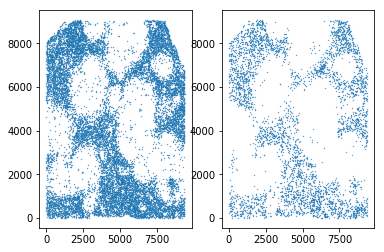

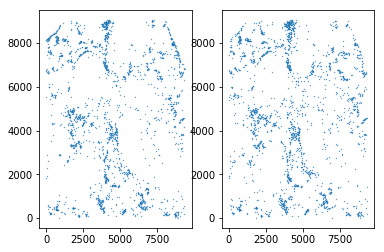

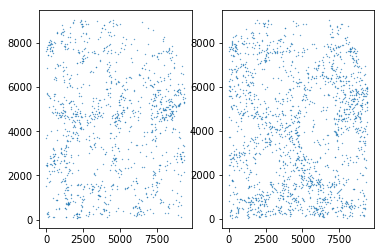

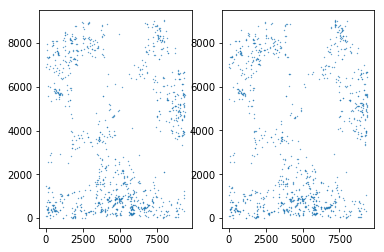

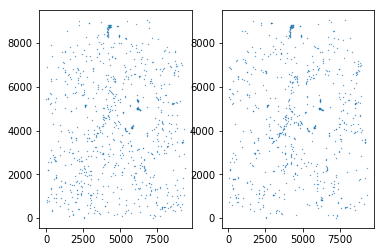

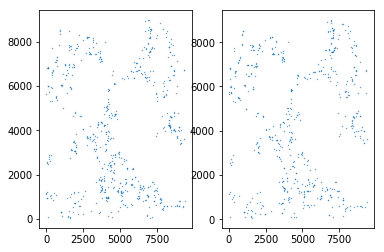

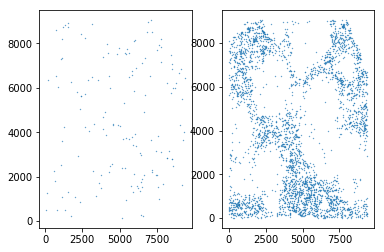

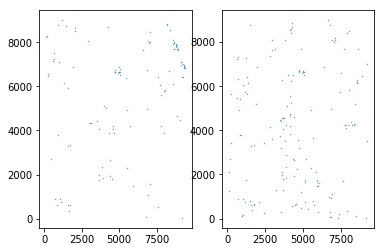

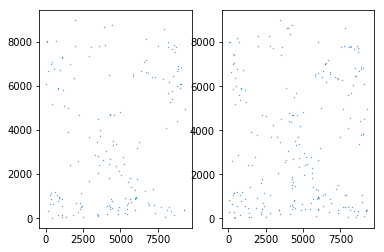

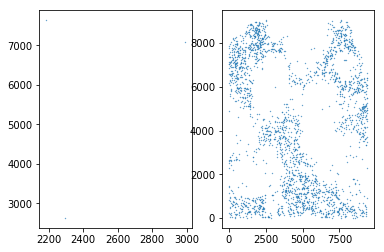

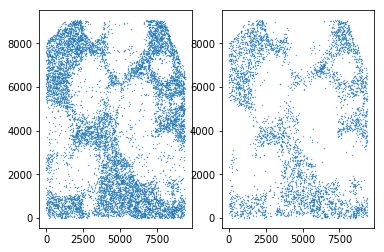

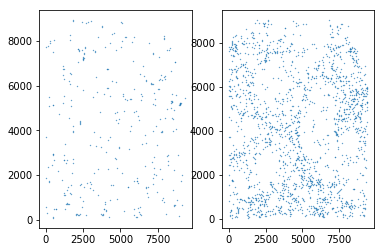

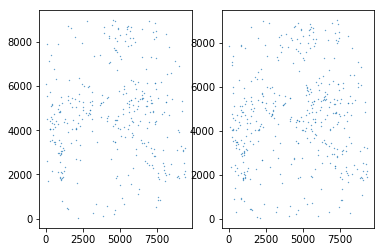

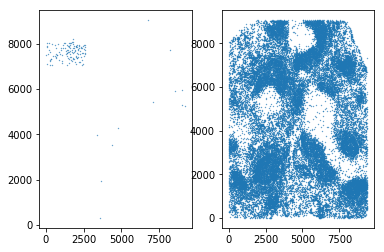

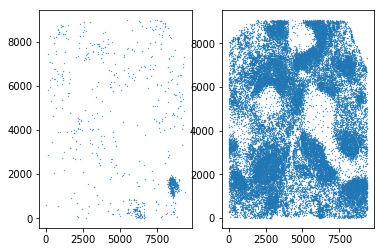

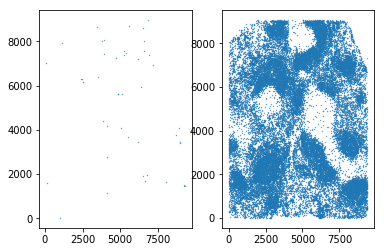

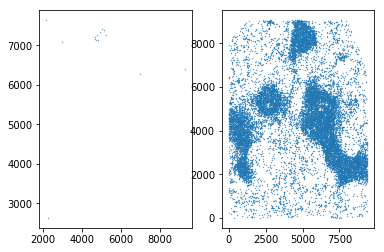

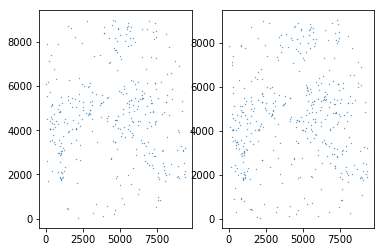

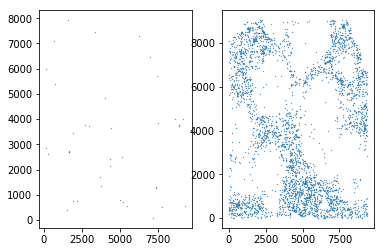

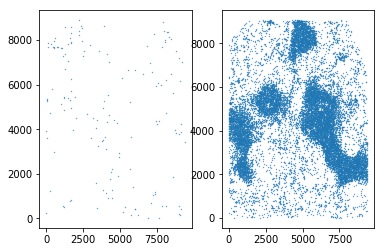

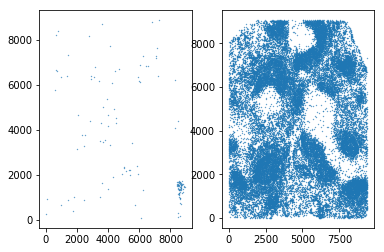

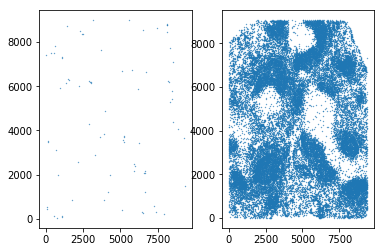

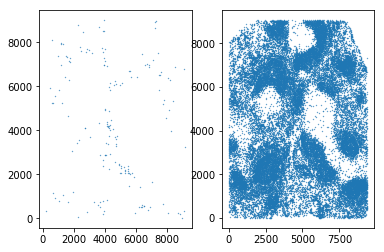

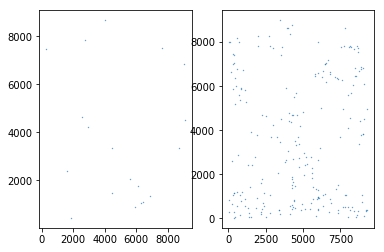

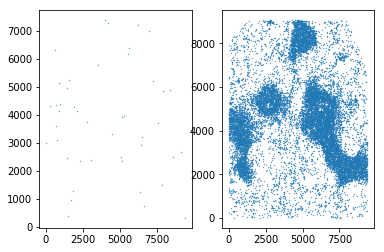

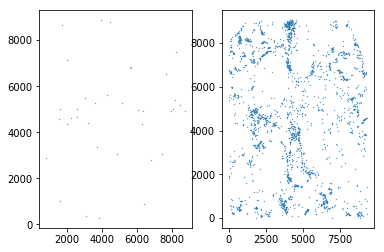

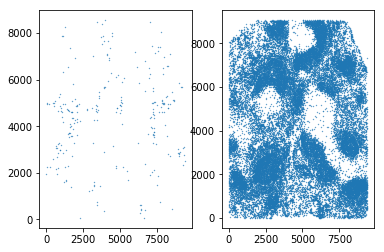

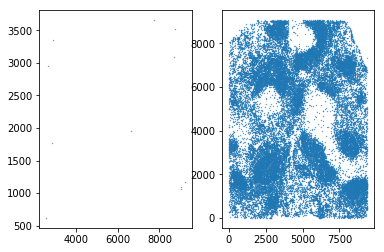

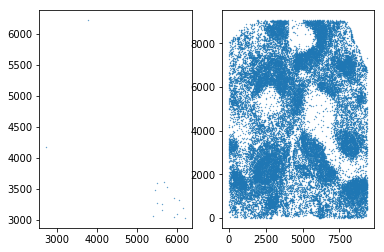

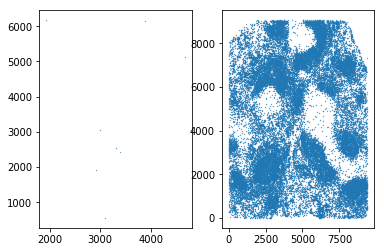

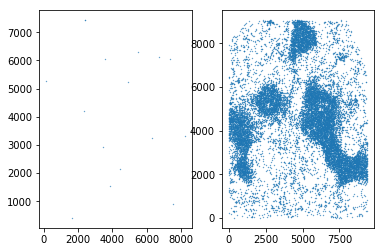

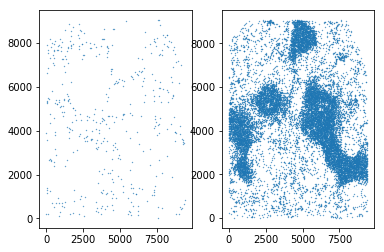

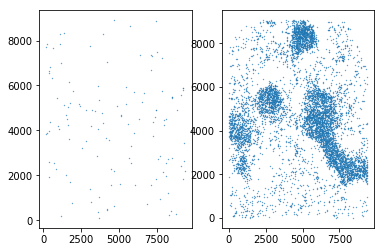

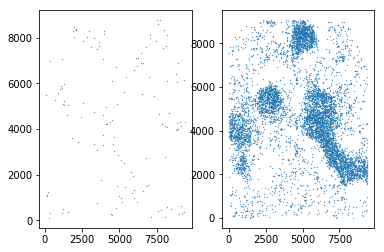

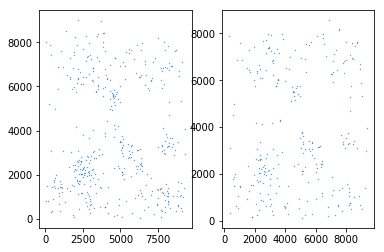

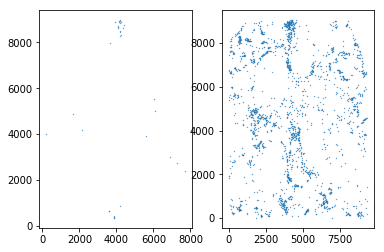

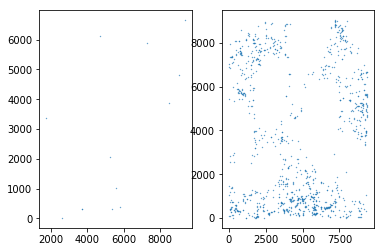

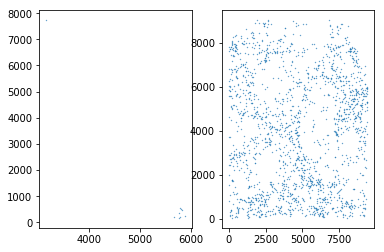

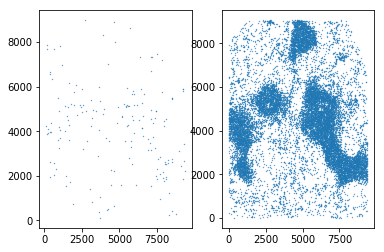

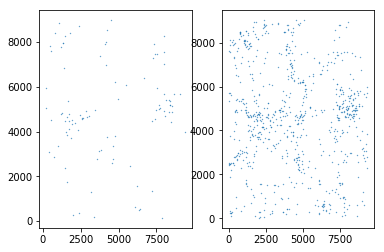

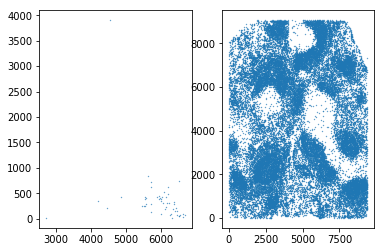

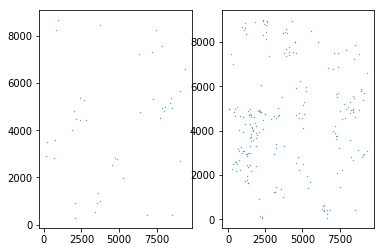

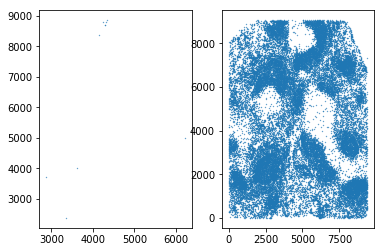

In [23]:
node_coords = [node.coords[['X', 'Y']] for node in parsed_metric_tree.iter_descendants()] 
suppl_image_coords = [group for _, group in suppl_image_groups]
find_corresponding_cluster(node_coords, suppl_image_coords)

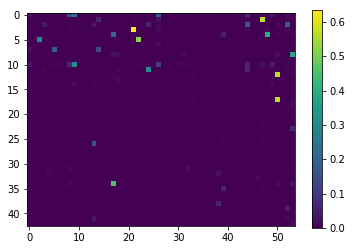

In [24]:
plot_cluster_overlap_heatmap(node_coords, suppl_image_coords)

Layer with 16 nodes


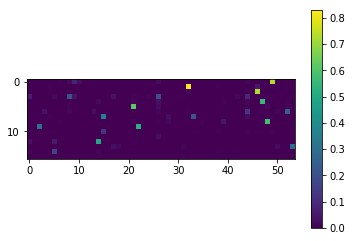

Layer with 17 nodes


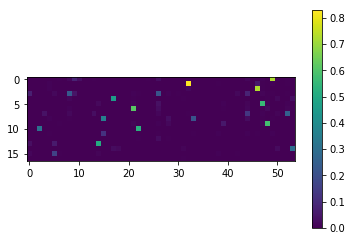

Layer with 18 nodes


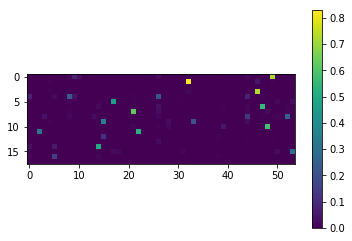

Layer with 17 nodes


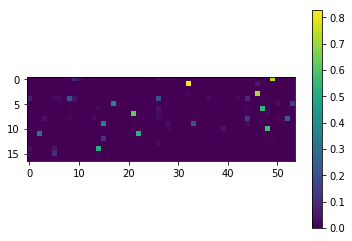

Layer with 18 nodes


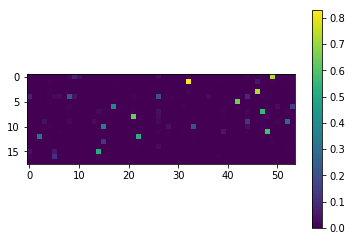

Layer with 19 nodes


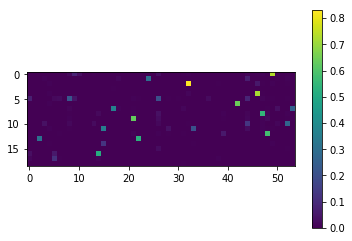

Layer with 21 nodes


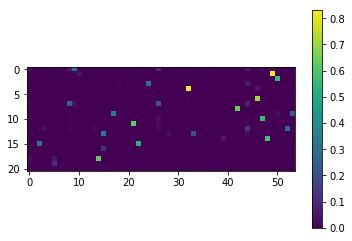

Layer with 22 nodes


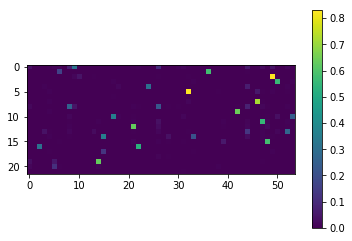

Layer with 21 nodes


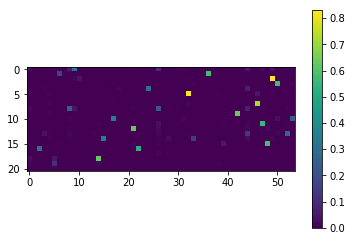

Layer with 20 nodes


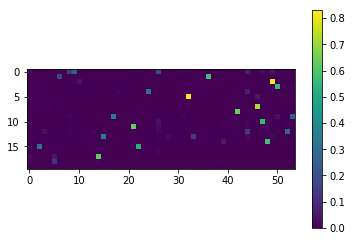

Layer with 21 nodes


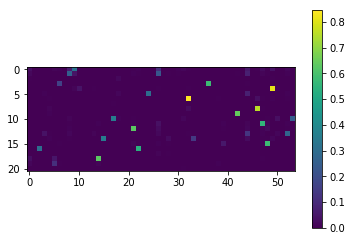

Layer with 22 nodes


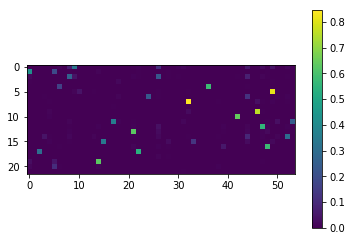

Layer with 23 nodes


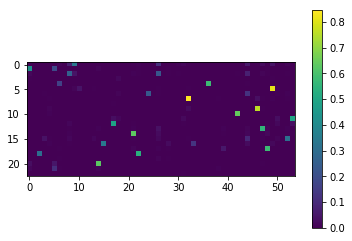

Layer with 24 nodes


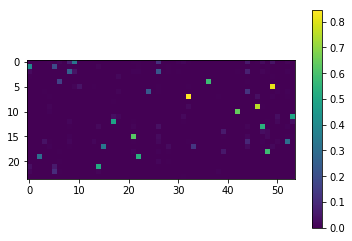

Layer with 22 nodes


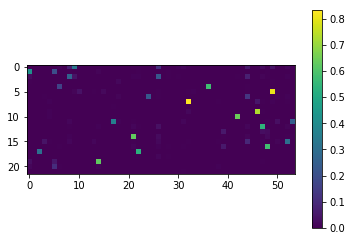

Layer with 24 nodes


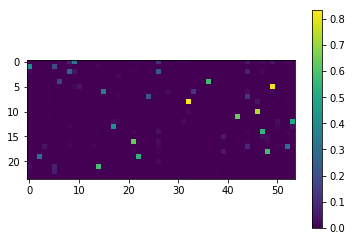

Layer with 27 nodes


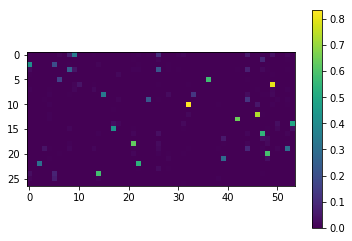

Layer with 29 nodes


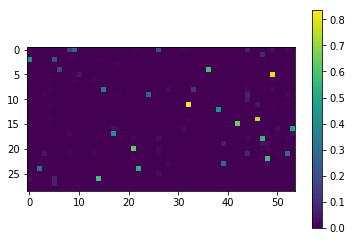

Layer with 28 nodes


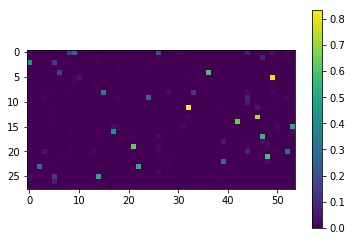

Layer with 30 nodes


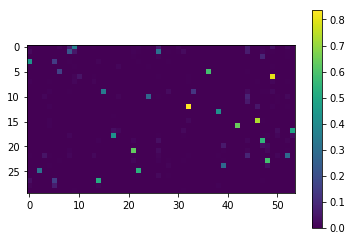

Layer with 31 nodes


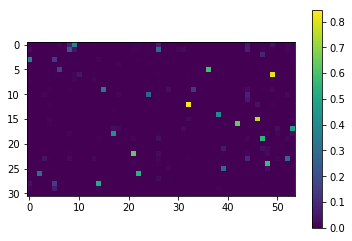

Layer with 32 nodes


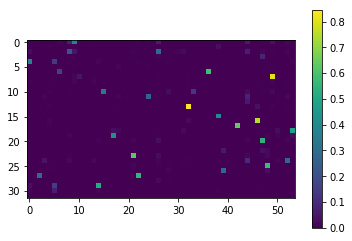

Layer with 33 nodes


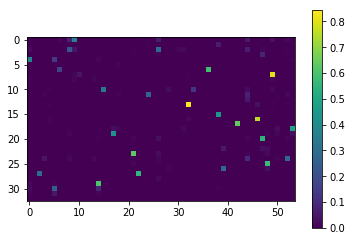

Layer with 34 nodes


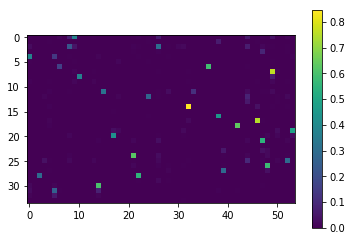

Layer with 36 nodes


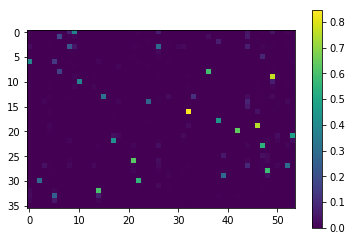

In [18]:
plot_layer_overlap_heatmap(tree, suppl_image_coords, num_layers=25)

## Rerun Above Analysis Over All Samples 

In [42]:
sample_name = 'combined'
num_clusters, num_neighbors = get_unique_clusters(sample_name)
pickle.dump((num_clusters, num_neighbors), open('combined_unique_clusters.pkl', 'wb'))
#num_clusters, num_neighbors = pickle.load(open('combined_unique_clusters.pkl', 'rb'))

In [43]:
fcs_paths = [data_dir + '/' + sample_name + '/' + str(nn) + '/out/' + sample_name + '.fcs' for nn in num_neighbors]
tree = build_sample_tree(sample_name, prop_filter=0.15)
tree = calculate_spearman_metric(tree)
pickle.dump(tree, open('combined_tree.pkl', 'wb'))
#tree = pickle.load(open('combined_tree.pkl', 'rb'))

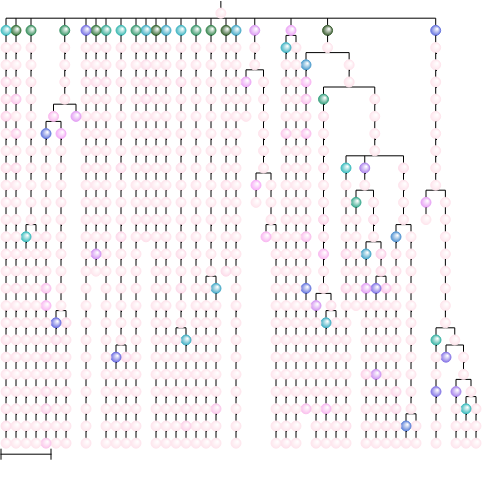

In [44]:
visualize_spearman_metric(num_layers=25, save=False)

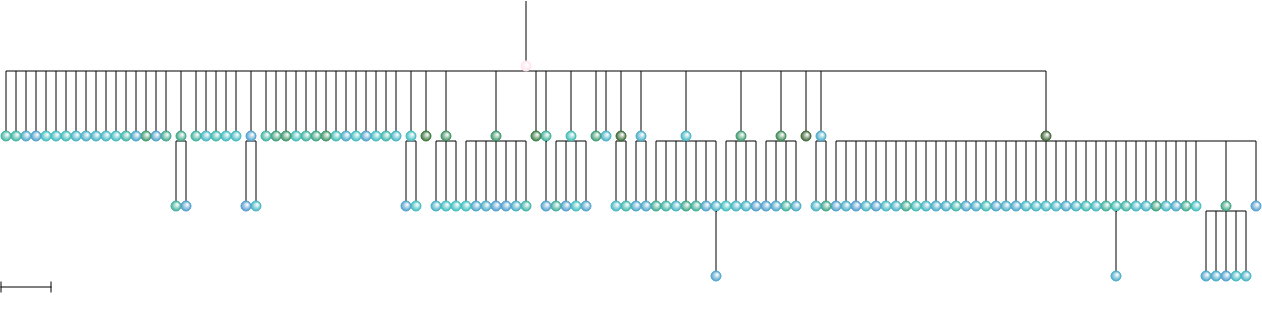

In [45]:
parse_metric_tree(tree, num_layers=None, cutoff=0.2, prevent_nondicotomic=False, save=False)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


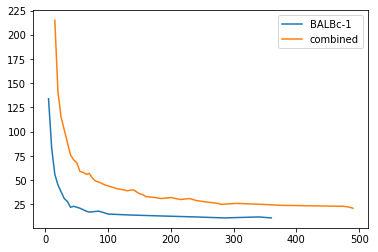

In [46]:
num_clusters_balbc1, num_neighbors_balbc1 = get_unique_clusters('BALBc-1')
num_clusters_combined, num_neighbors_combined = get_unique_clusters('combined')
plt.plot(num_neighbors_balbc1, num_clusters_balbc1, label='BALBc-1')
plt.plot(num_neighbors_combined, num_clusters_combined, label='combined')
plt.legend()
plt.show()

## Analyze Batch Effects in Samples 

In [22]:
# use cluster centroids from BALBc-1 to cluster others, and then compute mutual information between clusterings
_, balbc1_data = fcsparser.parse('BALBc-1/auto/out/BALBc-1.fcs')
balbc1_data = process_fcs(balbc1_data)
feature_cols = list(balbc1_data.columns[:29])
balbc1_data = balbc1_data[feature_cols + ['cluster_id']]
centroids = balbc1_data.groupby('cluster_id').apply(np.mean).reset_index(drop=True)

nn = NearestNeighbors(n_neighbors=1)
nn.fit(centroids[feature_cols].values)
remaining_samples = ['BALBc-2', 'BALBc-3', 'MRL-4', 'MRL-5', 'MRL-6', 'MRL-7', 'MRL-8']
for sample in remaining_samples:
    _, data = fcsparser.parse('{}/auto/out/{}.fcs'.format(sample, sample))
    data = process_fcs(data)
    data = data[feature_cols + ['cluster_id']]
    neighbors = nn.kneighbors(data[feature_cols].values, return_distance=False)[:, 0]
    score = mutual_info_score(data['cluster_id'].values, neighbors)
    print('Mutual info score for', sample, score)

/n/home05/aewhatley/anaconda3/lib/python3.6/site-packages/fcsparser/api.py:332: UserWarning: The default channel names (defined by the $PnS parameter in the FCS file) were not unique. To avoid problems in downstream analysis, the channel names have been switched to the alternate channel names defined in the FCS file. To avoid seeing this warning message, explicitly instruct the FCS parser to use the alternate channel names by specifying the channel_naming parameter.
  warnings.warn(msg)


Mutual info score for BALBc-2 1.41636526374
Mutual info score for BALBc-3 1.37650504709
Mutual info score for MRL-4 1.2100834789
Mutual info score for MRL-5 1.18374105547
Mutual info score for MRL-6 1.17162112009
Mutual info score for MRL-7 1.09305823328
Mutual info score for MRL-8 1.17512264796
